# Part4: Control a Marble with Reinforcement Learning

Fawad Ahmad

## Overview

In this i am considering the variable wind as a force on the marble, along with another state variable that indicates wind speed and direction. The formula of wind used for this is 
$$
\begin{align*}
 F = A * P * Cd
\end{align*}
$$

Where

$$
\begin{align*}
 A = Area of marble\\
 P = Wind Pressure\\
 Cd = Drag Coefficient
\end{align*}
$$

$$
\begin{align*}
 P = 0.613*V^2\\
\end{align*}
$$

This formula update the Wind force every time we call the next state. So once the force is calculated, we find the velocity it will cause on object by the formula 

$$
\begin{align*}
 F=1/2 * ρ * v^2 * Cd * A\\
\\
\end{align*}
$$

## Functions 

* $initialState$ takes the velocity and position of marbles randomly for the first time. whereas wind force, wind speed and wind direction given by the user.
* $nextState$ It updates position, velocity and Wind force. First it look into the current Action/movement of marble and the direction of the wind and then decide whether to decrease the velocity of marble or increase it. For that, it finds the force of the wind on the marble and it's effect on the velocity of marble and returns it.
* $reinforcement$ is to look for the goal and current position difference and reinforce accordingly.
* $policy$ is to get new action randomly or by looking into the qnet for a good action.
* $makeSamples$ is to get all the samples considering one starting point so that when we give it to the system, it learns better.
* $plotStatus$ is to generate different plots to show reinforcements,actions,NN, MaxQ and relation of position with velocity.


In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy
import math

%matplotlib inline

In [2]:
validActions = np.array([ -1, 0, 1 ]) 
# -1 is Left -2 is Left with low speed -3 is left with high speed  
def initialState(WF,WS,WD):
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()),WF,WS,WD])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1  
    A = 4 # because Wind force on marble will depend on projection area of marble
    Pc = 0.613 # constant for finding wind pressure 
    P = Pc*(2 ** s[3]) # Wind pressure on an object in Psf
    cs = 0.8 # drag coefficient on the marble by wind
    m = 3
    if s[4] !=0:
        s[0] += deltaT * s[1]
        if s[4] > 0 and a>0: # action direction and wind direction both to the right
            s[2] = A * P * cs * 0.5 * (s[1]+s[3]) # update the force on the object
            OV = math.sqrt(abs(2*s[2]/(A * P * cs*m))) # update velocity caused by wind force
            s[1] += (deltaT * (2 * a - 0.2 * s[1]) - OV) # so reduce the velocity  
        if s[4] > 0 and a<0: # action direction and wind direction are right and left
            s[2] = A * P * cs * 0.5 * (s[1]-s[3]) # update the force on the object
            OV = math.sqrt(abs(2*s[2]/(A * P * cs*m))) # update velocity caused by wind force
            s[1] += (deltaT * (2 * a - 0.2 * s[1]) + OV)  # increase the velocity
        if s[4] < 0 and a<0: #action direction and wind direction both to the left
            s[2] = A * P * cs * 0.5 * (s[1]+s[3]) # update the force on the object
            OV = math.sqrt(abs(2*s[2]/(A * P * cs*m))) # update velocity caused by wind force
            s[1] += (deltaT * (2 * a - 0.2 * s[1]) - OV)  # so reduce the velocity
        if s[4] < 0 and a>0:# action direction and wind direction are right and left
            s[2] = A * P * cs * 0.5 * (s[1]-s[3]) # update the force on the object
            OV = math.sqrt(abs(2*s[2]/(A * P * cs*m))) # update velocity caused by wind force
            s[1] += (deltaT * (2 * a - 0.2 * s[1]) + OV)  # increase the speed
    else:
        s[0] += deltaT * s[1]
        s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0,s[2],s[3],s[4]])
    elif s[0] > 10:
        s = np.array([10,0,s[2],s[3],s[4]])
    return s

def reinforcement(s):  # s is new state
    goal = 8
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
            inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
            qs = qnet.use(inputs)
            actioni = np.argmax(qs)
    return validActions[actioni]

Now we need a function to generate a bunch of samples that are interactions with the marble.

In [3]:
def makeSamples(qnet, nStepsPerStart,WF,WS,WD):
    samples = []
    state = initialState(WF,WS,WD)
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

Now we can play.  Define constants we need.

In [4]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace,goal):
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [goal,goal],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[qnet.use([s,0,a]) for a in actions] for s in range(11)]
    qs = qnet.use(np.array([[s,0,0,0,0,a] for a in validActions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([goal-1,goal +1],[-20,-20],[20,20],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-20,20)
    plt.subplot(4,3,6)
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])

    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],0,0,0,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    plt.subplot(4,3,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")

    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")

def testIt(qnet,nTrials,nStepsPerTrial,goal):
    xs = np.linspace(0,10,nTrials)
    plt.subplot(4,3,12)
    for x in xs:
        s = [x,0] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,2))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([goal,goal],[-goal,goal],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [5]:
gamma = 0.999
nTrials = 1000
nStepsPerTrial = 1000 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

In [6]:
epsilonDecay

0.99540541735152699

In [7]:
nh = [10,10]
qnet = nn.NeuralNetwork([6] + nh + [1])  # [3, 5, 5, 1]


### Program for wind with positive direction

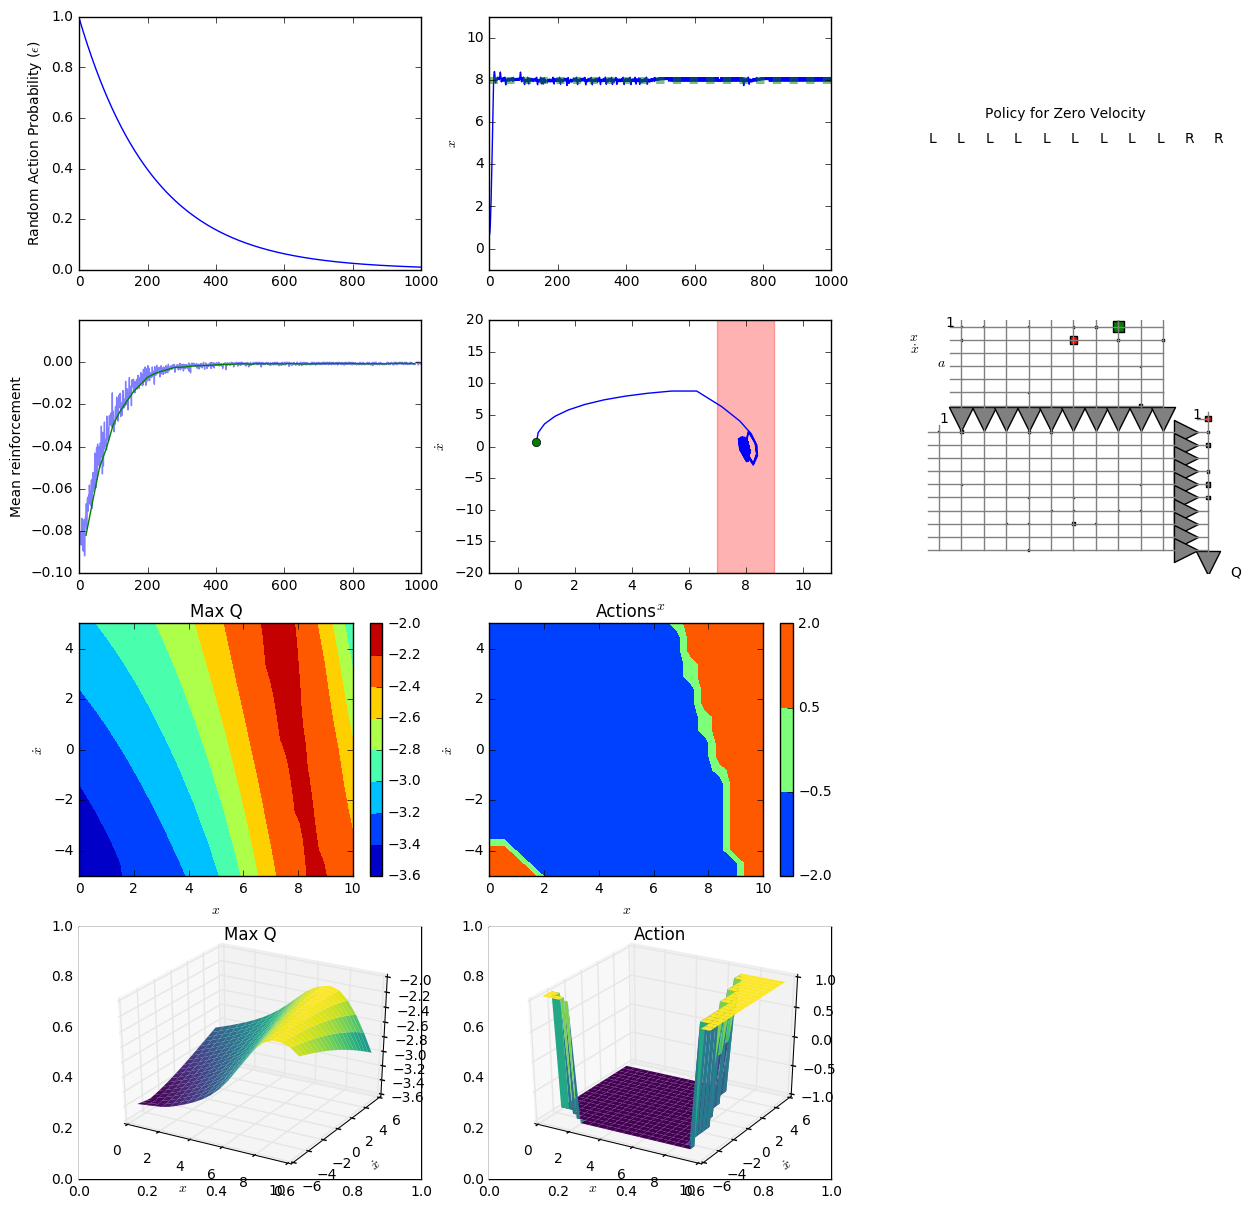

In [8]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 8
for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,25,10,1)

    ns = 5
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### Analysis
* There is a lot of fluctuation on the goal as there is a wind factor to control.
* velocity and position graph shows that alot of velocity fluctuation is required to settle down.

### Program of wind with negative direction

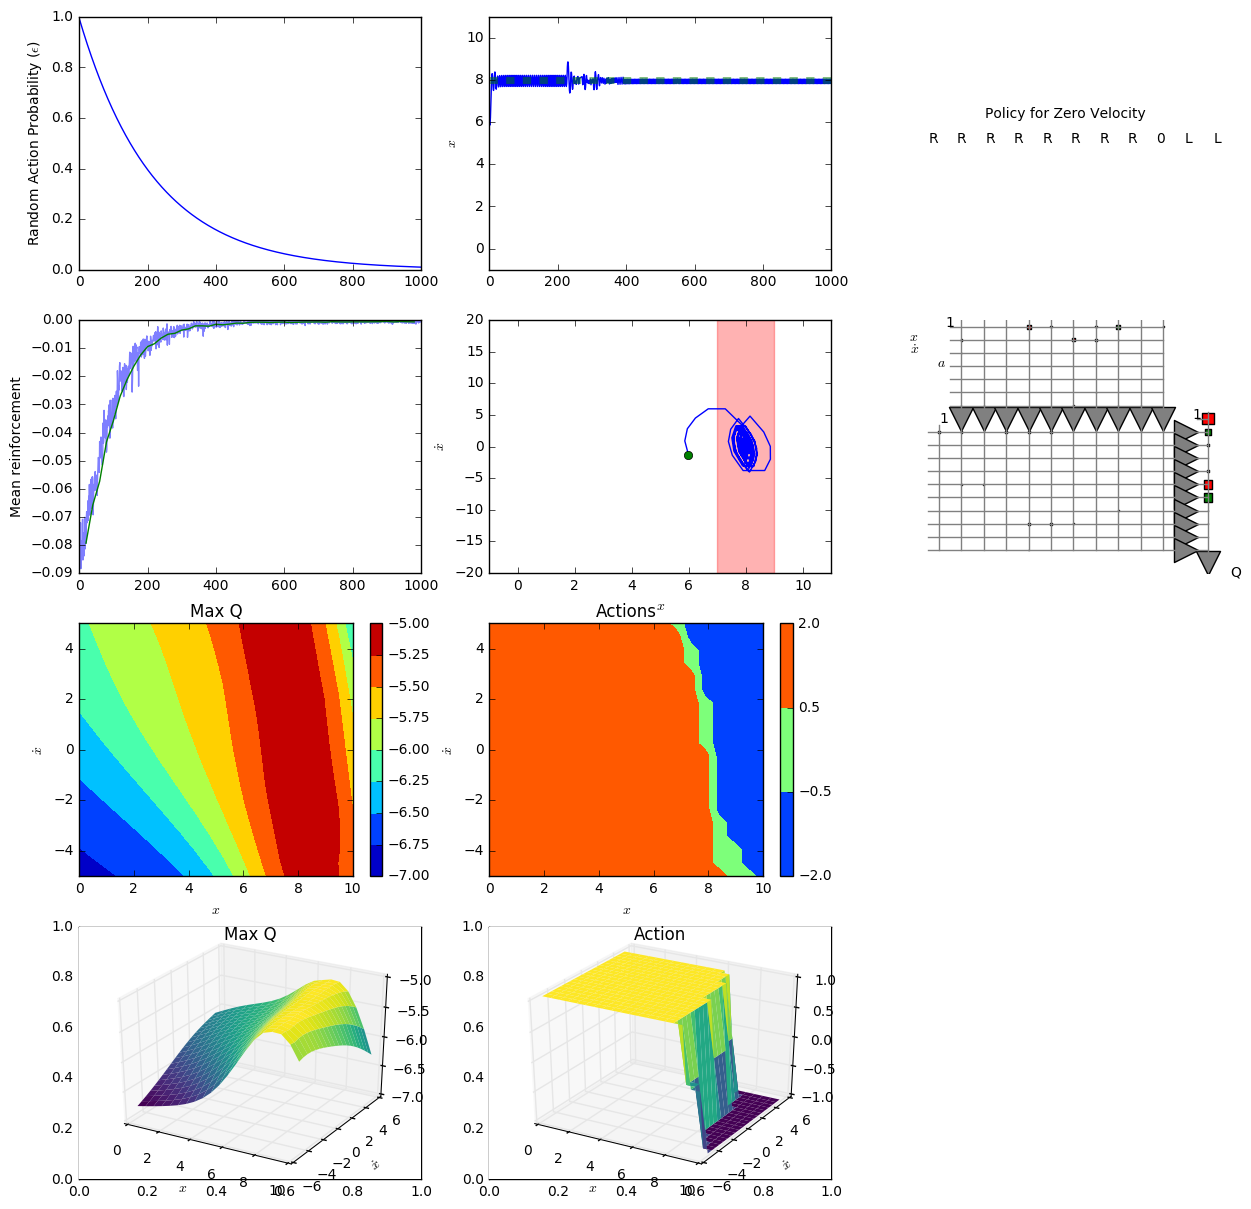

In [15]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 8
for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,25,10,-1)

    ns = 5
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### Analysis
* Just like before there is a lot of fluctuation at the goal and the marble has to adjust alot to cater for the force.

### Program of wind with no direction

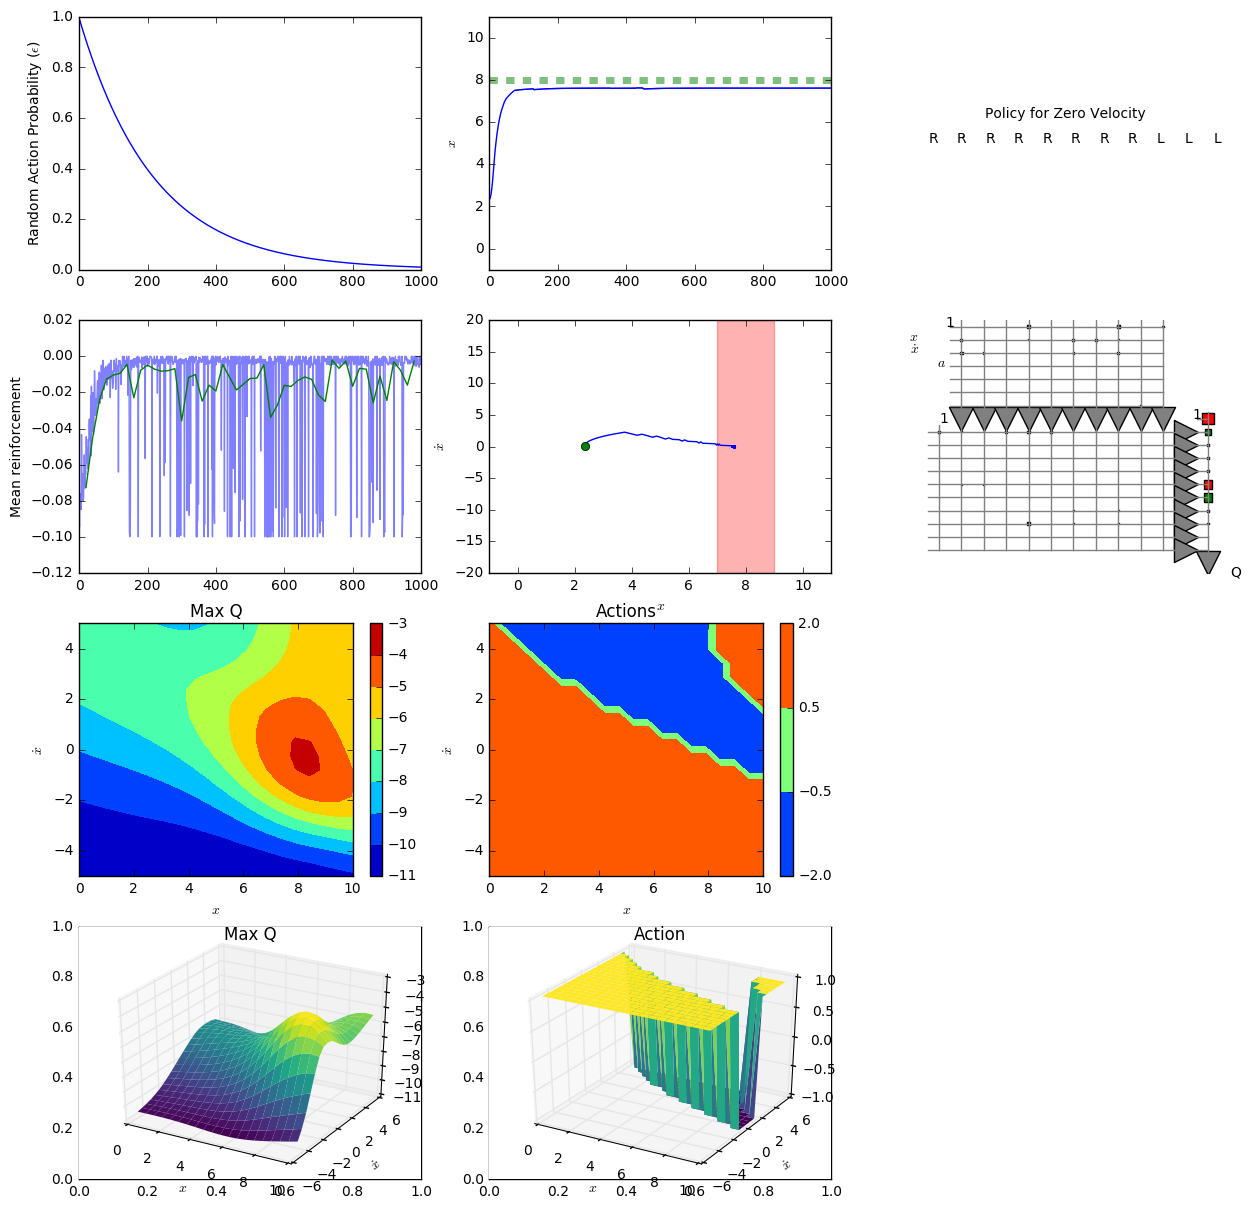

In [13]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 8
for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,25,10,0)

    ns = 5
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### Analysis
As there is no force now so the marble don't have to act like before, so as shown in the diagrams it approach the goal easily.

## Overall Analysis

Following are the observations made.
* As there is a force caused by the wind so the system takes bit longer to get trained fully shown by the reinforcement graph.
* There are more fluctuations at goal shown in second and fifth graph as there is a force of wind which effect.
* The overall system learns well how to approach goal.
* without wind the system has no problem approaching the goal.